# Geonutrition Data Analysis

In [1]:
# source('/home/jovyan/codes/Assorted/Download_data.R')

In [2]:
list.files('/home/jovyan/CIMMYT_Geonutrition/Clean ionomic data')

[1] "ETH_MWI_icp_grain.csv"    "MWI_GeoN_spectral.zip"   
[3] "MWI_grain_CoDa.csv"       "MWI_soil_mir_spectra.csv"

## Read in the data downloaded

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
prospectr version 0.2.6 -- 'chicago'

check the github repository at: https://github.com/l-ramirez-lopez/prospectr/

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ recipes      1.0.1
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ sc

'data.frame':	1808 obs. of  22 variables:
 $ csid  : chr  "GeoN-MW-Crop-0147" "GeoN-MW-Crop-0148" "GeoN-MW-Crop-0149" "GeoN-MW-Crop-0150" ...
 $ ssid  : chr  "GeoN-MW-Soil-0147" "GeoN-MW-Soil-0148" "GeoN-MW-Soil-0149" "GeoN-MW-Soil-0150" ...
 $ lat   : num  -14.9 -14.9 -14.9 -14.9 -14.9 ...
 $ lon   : num  34.8 34.7 34.8 34.7 34.7 ...
 $ crop  : chr  "maize" "maize" "maize" "maize" ...
 $ source: chr  "crop" "crop" "store" "store" ...
 $ fert  : chr  "y" "y" "y" "n" ...
 $ Na    : num  0.812 0.812 0.812 0.812 0.812 0.812 0.812 0.812 0.812 0.812 ...
 $ Mg    : num  884 1197 1518 1156 894 ...
 $ P     : num  1759 3169 4137 3068 2379 ...
 $ S     : num  1461 1558 1546 1622 1113 ...
 $ K     : num  2719 4112 5058 3727 3433 ...
 $ Ca    : num  49.9 45.6 219.1 49.5 52.2 ...
 $ Cr    : num  1.498 0.073 2.032 0.02 0.359 ...
 $ Mn    : num  6.9 4.95 7.5 4.15 3.67 ...
 $ Fe    : num  25.9 20.2 31.1 26.7 16.4 ...
 $ Co    : num  0.051 0.0067 0.032 0.01 0.01 0.018 0.021 0.023 0.032 0.01 ...
 $ Cu 

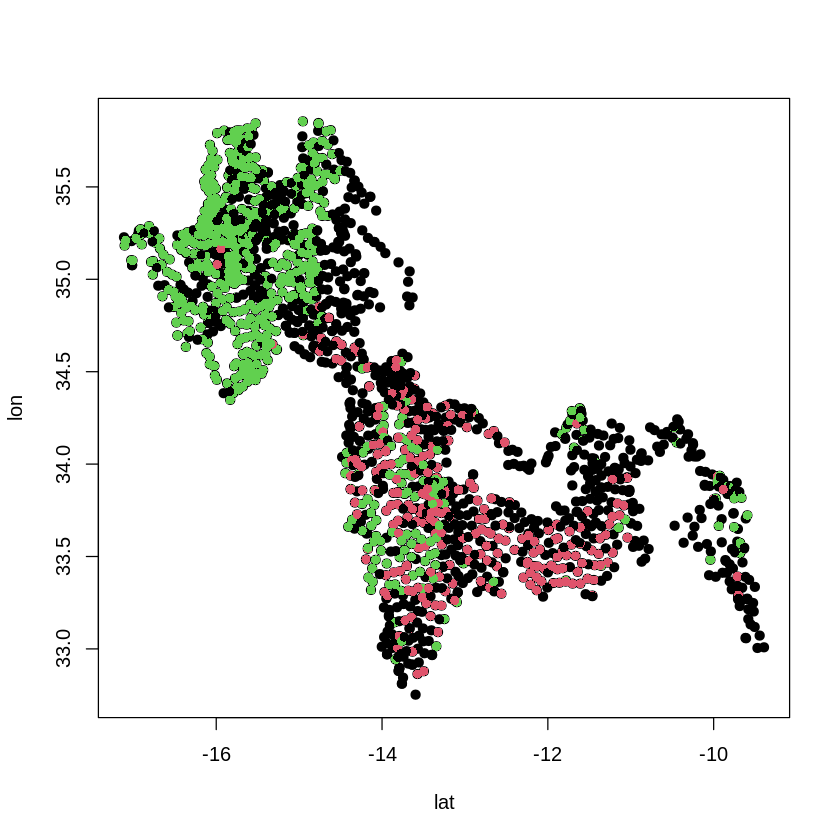

In [3]:
# Read data
library(tidyverse)
library(prospectr)
library(clhs)
library(rsample)
library(tidymodels)

setwd('/home/jovyan/CIMMYT_Geonutrition/Clean ionomic data')

#list.files()

grain <- read.csv('MWI_grain_CoDa.csv')

str(grain)

with(grain, plot(lat, lon), type = "n")

with(grain, points(lat, lon, col = as.factor(source), pch = 16))



### Determine whether spectral data matches the concentration one

In [4]:
soil <- read.csv('MWI_soil_mir_spectra.csv')

m <- which(!soil$ssid %in% grain$ssid)

n <- which(!grain$ssid %in% soil$ssid)

length(m); length(n)

length(soil$ssid); length(grain$ssid)

grain$ssid[c(n,n-1,n+1)]

[1] 21

[1] 3

[1] 1826

[1] 1808

[1] "GeoN-MW-Soil-0955" "GeoN-MW-Soil-1046" "GeoN-MW-Soil-1946"
[4] "GeoN-MW-Soil-0954" "GeoN-MW-Soil-1045" "GeoN-MW-Soil-1945"
[7] "GeoN-MW-Soil-0956" "GeoN-MW-Soil-1047" "GeoN-MW-Soil-1947"

### Preprocess raw soil spectra before merging with grains

In [5]:
# Preprocess soil spectra using 
# Merge grain data with soil spectra

# 1. Get first derivative with Savitzky_Golay

specd <- savitzkyGolay(soil[,-1], m = 1, p =2, w = 23)

# Take SNV

specdsnv <- standardNormalVariate(specd)

spec0 <- as.data.frame(specdsnv)

### Work with MIR region only.
#### EXclude NIR region above 4004 wavenumbers

In [6]:
# Drop the noisy NIR spectral regions to work with MIR part only

mir <- which(as.numeric(gsub('m','',colnames(spec0))) < 4004)

spec0 <- spec0[,mir]

### Select training and testing samples from spectral PCA space

In [7]:
pcs <- prcomp(spec0)

pc <- pcs$x[,1:10]

pc <- as.data.frame(pc)

## Two approaches for sample selection
### Approach 1 using conditioned latin hypercube sampling

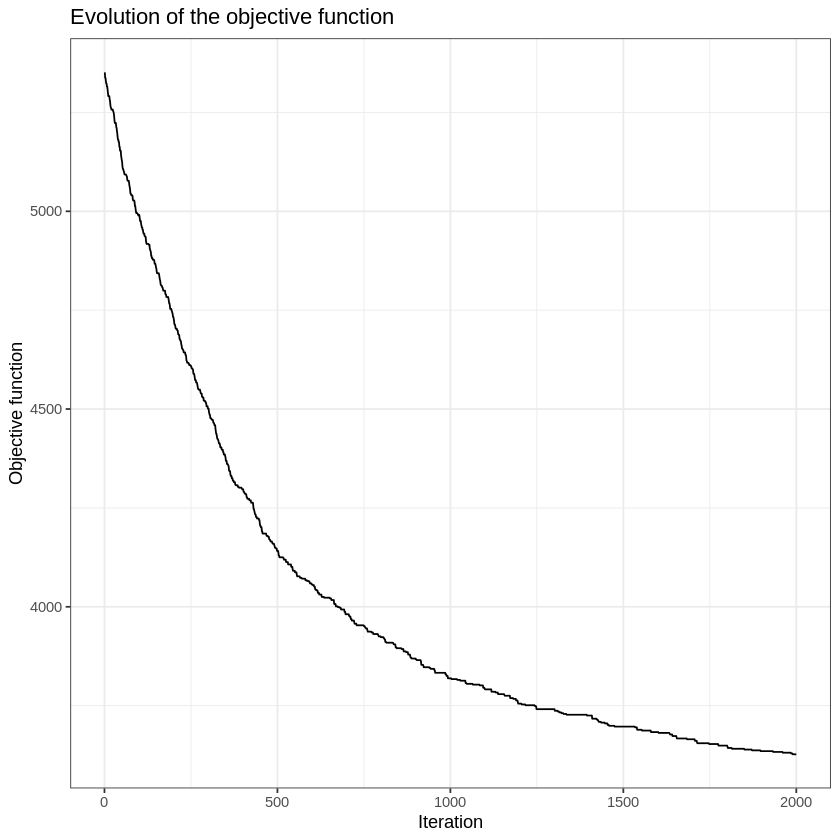

,ssid,m4003.5,m4001.6,m3999.7,m3997.8,m3995.8,m3993.9,m3992
,"<chr[,1]>",<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
695,GeoN-MW-Soil-1008,0.04418116,0.04470964,0.04554002,0.04727931,0.04850493,0.04894798,0.04938992
1191,GeoN-MW-Soil-1965,0.01425004,0.01360279,0.01366945,0.01492362,0.01536162,0.01469148,0.01413050


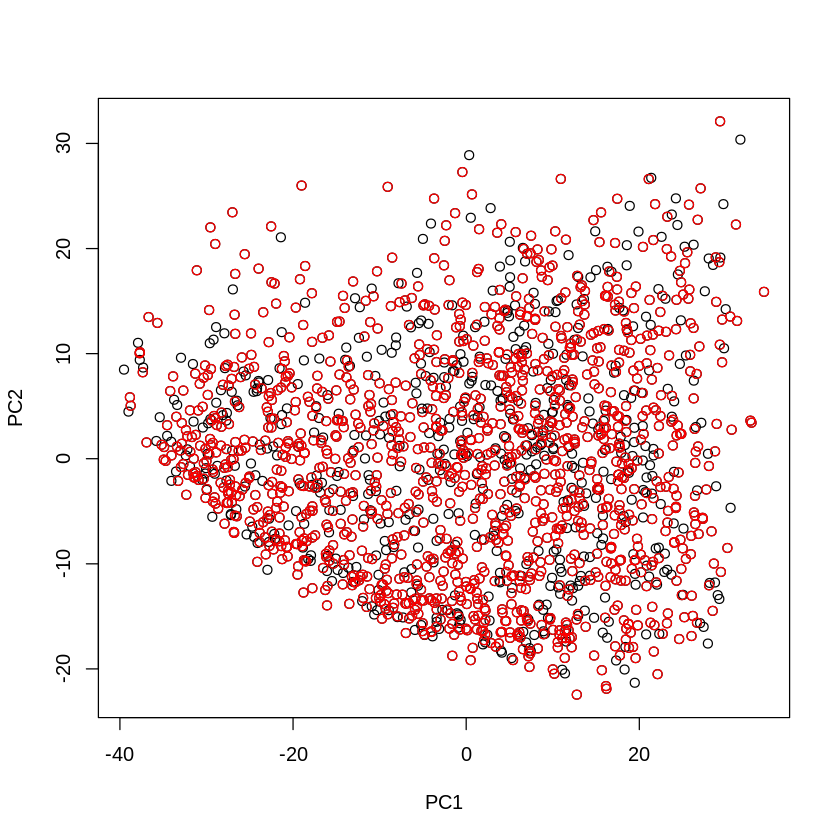

In [8]:
size <- round(0.70 * nrow(spec0)) #or specify size manually

set.seed(2731)

sel_index <- clhs(pc, size = size, progress  = TRUE, iter = 2000, simple = FALSE)

plot(sel_index)

plot(pc[,1:2])

points(pc[sel_index$index_samples,1:2], col = 'red')

k <- sel_index$index_samples # Get the selected for training

spec0 <- spec0 %>%
	mutate(ssid = as.matrix(soil[,1])) %>%
	select(ssid, everything())

	    
spec0[k[1:2],1:8]

### Approach 2 using split from rsample package

In [9]:
# Get the grain labels 
cgrains <- c('ssid','Na', 'Mg', 'P', 'S', 'K','Ca','Cr', 'Mn', 'Fe', 'Co', 'Cu', 'Zn', 'Se', 'Mo', 'I')

grain_soil  <-  left_join(grain[,c('ssid','Mg')], spec0, by = 'ssid')

# Select by rsample
# split train and test data from grain_soil
# set seed 

set.seed(2021)
spl <- initial_split(grain_soil, strata = "Mg")
train <- training(spl)
test <- testing(spl)

### Start models

In [ ]:

train_5fold <- train %>%
  vfold_cv(5)

mset <- metric_set(rmse, rsq, ccc) # 3 metrics
control <- control_grid(save_workflow = TRUE,
                        save_pred = TRUE,
                        extract = extract_model) # grid for tuning
                        
                       
                       # First recipe
                       
xg_rec <- recipe(Mg ~ ., data = train %>% select (-'ssid')) 

xg_model <- boost_tree(mode = "regression", # continous response
                       trees = tune(),
                       mtry = tune(),
                       tree_depth = tune(),
                       learn_rate = tune(),
                       loss_reduction = tune(),
                       min_n = tune()) # parameters to be tuned
                       
               
                       xg_wf <- 
  workflow() %>% 
  add_model(xg_model) %>% 
  add_recipe(xg_rec)

xg_tune <- xg_wf %>%
  tune_grid(train_5fold,
            metrics = mset,
            control = control,
            grid = crossing(trees = 1000,
                            mtry = c(150, 500, 900), # finalize(mtry(), train)
                            tree_depth = c(5, 10, 15),
                            learn_rate = c(0.01, 0.005),
                            loss_reduction = c(0.01, 0.1, 1),
                            min_n = c(2, 10, 25)))
# Visualize results
#autoplot(xg_tune)

In [11]:
install.packages('xgboost')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

